# Учебный проект e-commerce: анализ покупок пользователей, работы службы доставки, когортный анализ и RFM-сегментация

Таблицы:

 olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя


olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки


olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара


Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [1]:
import pandas as pd
import urllib
import json
import datetime
from calendar import monthrange
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import attrgetter

In [2]:
# Прочитаем датасеты, посмотрим на них и проведем предобработку данных, где это необходимо

In [3]:
folder_url = 'https://disk.yandex.ru/d/jkakPT052F9ERg'
file_url = 'olist_customers_dataset.csv'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)


In [4]:
r = requests.get(url)
h = json.loads(r.text)['href']

In [5]:
customers_df = pd.read_csv(h, sep=',') 
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
#проверяем типы данных
customers_df.dtypes
#менять типы данных не стоит

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
folder_url = 'https://disk.yandex.ru/d/jkakPT052F9ERg'
file_url = 'olist_orders_dataset.csv'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)


In [8]:
r = requests.get(url)
h = json.loads(r.text)['href']

In [9]:
orders_df = pd.read_csv(h, sep=',') 
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
#проверяем типы данных
orders_df.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [11]:
# Меняем тип данных на datetime, где это необходимо
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df.order_purchase_timestamp)
orders_df['order_approved_at'] = pd.to_datetime(orders_df.order_approved_at)
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df.order_delivered_carrier_date)
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df.order_delivered_customer_date)
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df.order_estimated_delivery_date)

In [12]:
# Проверяем
orders_df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [13]:
older_url = 'https://disk.yandex.ru/d/jkakPT052F9ERg'
file_url = 'olist_order_items_dataset.csv'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)

In [14]:
r = requests.get(url)
h = json.loads(r.text)['href']

In [15]:
items_df = pd.read_csv(h, sep=',')
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
# Проверяем типы данных
items_df.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [17]:
# Меняем тип данных на datetime, где это необходимо
items_df['shipping_limit_date'] = pd.to_datetime(items_df.shipping_limit_date)

In [18]:
# Проверяем
items_df.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

## Выясним, что именно будет считаться покупкой

In [19]:
# Для начала посмотрим, какие бывают статусы заказов (order_status) и как часто они встречаются (orders_df)
orders_df.value_counts('order_status')

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
dtype: int64

In [20]:
orders_df.query('order_status=="canceled"')
# Этот запрос показывает, что заказы иногда отменяются после подтверждения оплаты заказа (approved), после отправки заказа(shipped).

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
...,...,...,...,...,...,...,...,...
98791,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10
99143,6560fb10610771449cb0463c5ba12199,0d07d0a588caf93cc66b7a8aff86d2fe,canceled,2017-10-01 22:26:25,2017-10-01 22:35:22,NaT,NaT,2017-10-27
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01


In [21]:
# Проверим, отменялись ли заказы после доставки покупателю
orders_df.query('order_status=="canceled" and order_delivered_customer_date != "NaT"').shape
#да, несколько таких есть

(6, 8)

In [22]:
# А сколько заказов отменилось после отправки (order_delivered_carrier_date)?
orders_df.query('order_status=="canceled" and order_delivered_carrier_date != "NaT"').shape

(75, 8)

In [23]:
orders_df.query('order_status=="canceled" and order_approved_at != "NaT"').shape
# Большинство заказов отменяют после подтверждения оплаты.

(484, 8)

Будем считать покупками только заказы со статусом "delivered". Все еще есть небольшой риск, что заказ будет отменен, но вариантов лучше нет (так, например, статус "approved" не гарантирует, что заказ в итоге не будет отменен).

Отмененные заказы к покупкам относиться не будут. В большинстве случаев заказы отменяют после оплаты и до отправки и доставки, что означает, что при отмене, как правило, покупатели чаще передумывают совершать покупку (то есть фактически ее не совершают), чем решают вернуть товар. Товары, отмененные после доставки, также не будут учитываться в качестве покупок. Нам не известные точные причины отмены заказа, тем более во всей таблице таких кейсов всего 6. 

Таким образом, покупками считаются заказы со статусом "delivered"



## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [24]:
# Для начала проверим, что означает "позаказный идентификатор пользователя" (customer_id).
orders_df.customer_id.nunique()
# Количество уникальных customer_id совпадает с количеством строк в таблицах заказов и покупателей. 
# Вряд ли все пользователи совершили по одному заказу. 
# Значит, чтобы проанализировать поведение каждого пользователя, нам можно использовать только столбец customer_unique_id

99441

In [88]:
customers_df.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [89]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [90]:
# Объединим таблицу пользователей и таблицу заказов по колонке customer_id, чтобы собрать вместе уникальные ID пользователей и их заказы
customers_orders_df = customers_df.merge(orders_df, on='customer_id')
customers_orders_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [28]:
customers_orders_df.query('order_status=="delivered"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_orders'}) \
    .value_counts('num_orders')
# Оставляем в объединенном датафрейме только покупки (доставленные заказы)
# Группируем по уникальному ID пользователя
# Считаем количество покупок у каждого пользователя
# Переименовываем колонку с количеством покупок
# Считаем сколько пользователей совершило то или иное количество покупок

num_orders
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
15        1
9         1
dtype: int64

## Ответ - 1 покупку совершили 90557 пользователей

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [91]:
# Недоставленными будем считать заказы с отсутствием значения в столбце order_delivered_customer_date (датафрейм - orders_df).
undelivered = orders_df.query('order_delivered_customer_date == "NaT"')
undelivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


In [92]:
# Многие из заказов не доставлены, так как находятся на определенном этапе (например, статус заказа processing или shipped)
# Проверим, есть ли заказы, застрявшие на этих этапах, или на данный момент такие заказы просто не успели доставиться
orders_df.order_purchase_timestamp.sort_values(ascending=False).head(1)
# Дату последнего оформления заказа будем считать "сегодняшним" днем.
# Если у пока что не доставленного заказа последняя дата доставки должна была наступить раньше 2018-10-17,то он будет считаться недоставленным. 
# Исключим из таблицы undelivered заказы, которые на данный момент не доставлены, так как последняя дата доставки не наступила

60938   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [94]:
undelivered = undelivered.query('order_estimated_delivery_date < "2018-10-17" or order_status == "canceled" or order_status == "unavailable"')
undelivered
# Всего в данных 2965 недоставленных заказов (кроме тех, которые пока что не успели доставить)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [95]:
# Теперь надо понять, сколько месяцев охватывают наши данные
# В месяц в среднем - общее количество, разделенное на количество месяцов
orders_df.order_purchase_timestamp.sort_values(ascending=False).tail(1)
# Самый первый заказ
# Разница между первым и последним заказом - 25.4 месяца

4541   2016-09-04 21:15:19
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [96]:
undelivered_by_status = undelivered.groupby('order_status', as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'num_orders'}) \
    .sort_values('num_orders', ascending=False)
# Получили датафрейм с общим количеством недоставленных заказов в зависимости от причины (статуса заказа)
undelivered_by_status

,order_status,num_orders
6,shipped,1107
1,canceled,619
7,unavailable,609
4,invoiced,314
5,processing,301
3,delivered,8
2,created,5
0,approved,2


In [97]:
undelivered_by_status['num_orders']=undelivered_by_status['num_orders']/25.4
undelivered_by_status
# После деления колонки num_orders на количество месяцов, мы получили среднее количество отмененных заказов по каждому статусу в месяц

,order_status,num_orders
6,shipped,43.582677
1,canceled,24.370079
7,unavailable,23.976378
4,invoiced,12.362205
5,processing,11.850394
3,delivered,0.314961
2,created,0.196850
0,approved,0.078740


Судя по всему, чаще всего заказы пропадают на этапе доставки. Вероятнее всего, компания не успевает их доставить в срок
Примерно с одинаковой частотой заказы отменяются и становятся недоступными
Реже последним статусом недоставленного заказа становится invoiced - примерно 12 покупателей в месяц не оплачивают заказы.
Стоит отметить, что за все время нашлось 8 недоставленных заказов (нет данных о дате доставки) со статусом delivered. Вероятно, в данных есть ошибка

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [98]:
# Для начала объединим таблицы orders_df и items_df, чтобы сопоставить время заказа с товарами в нем
orders_items_df = orders_df.merge(items_df, on='order_id')
orders_items_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [99]:
# Днем покупки будем считать день создания заказа (order_purchase_timestamp), так как интересно именно то, в какие дни этим товаром интересуются.
# Создадим колонку с соответсвующими дню создания заказа днями недели.

# В этом задании не убираем отмененные, недоступные и недоставленные заказы. Это нужно, чтобы не исказать данные о популярности товаров в определенные дни недели.

In [100]:
intoweekday = lambda x: x.weekday()
# Создали функцию, которую можно применить к нужной колонке

In [101]:
orders_items_df['weekday']=orders_items_df.order_purchase_timestamp.apply(intoweekday)

In [102]:
orders_items_df.head()
# Теперь в таблице есть колонка, соответствующая дню недели, когда был куплен товар: от 0 (понедельник) до 6 (воскресенье)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,1


In [103]:
# Cгруппируем товары по их ID и посмотрим, в какой день недели купили самое большое количество тех или иных товаров
week_and_count_df = orders_items_df.groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'num_orders'}) \
    .sort_values('num_orders', ascending=False) \
    .drop_duplicates('product_id')
week_and_count_df.head()
# Получился датафрейм, в котором содержится информация о каждом ID товара, дне недели, в который этот товар купили наибольшее количество раз, количестве этого товара,купленного в данный день недели.

,product_id,weekday,num_orders
15898,422879e10f46682990de24d770e7f83d,2,93
36512,99a4788cb24856965c36a24e339b6058,0,92
41044,aca2eb7d00ea1a7b8ebd4e68314663af,3,89
20123,53b36df67ebb7c41585e8d54d6772e08,1,76
13002,368c6c730842d78016ad823897a372db,4,67


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [104]:
# Создадим датасет, в котором оставим только совершенные покупки (доставленные заказы). Получим его из уже соединенных таблиц с данными о покупателях и заказах
customers_buyings_df = customers_orders_df.query('order_status=="delivered"')
customers_buyings_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [105]:
# Создадим колонку с месяцем и годом совершения покупки (будем считать, как и в прошлом задании по колонке order_purchase_timestamp)

In [107]:
customers_buyings_df['year_month']=customers_buyings_df['order_purchase_timestamp'].astype('datetime64[M]')
customers_buyings_df.head()
# Теперь в датафрейме есть колонка, где дата создания заказа приведена к началу месяца


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-01


In [108]:
customers_buyings_months_df = customers_buyings_df.groupby(['customer_unique_id', 'year_month'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_buyings'})
customers_buyings_months_df.head()
# Датафрейм, в котором указаны ID покупателей, месяц и год, количество покупок

,customer_unique_id,year_month,num_buyings
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1


In [109]:
# Теперь нужно создать функцию, которая будет для каждого месяца подсчитывать количество недель в нем
# С помощью monthrange считаем количество дней и делим на 7, чтобы получить точное количество недель
num_weeks = lambda x: monthrange(x.year, x.month)[1]/7

In [110]:
customers_buyings_months_df['num_weeks'] = customers_buyings_months_df.year_month.apply(num_weeks)
customers_buyings_months_df.head()
# Теперь в датафрейме есть колонка, указывающая на количество недель для данного месяца

,customer_unique_id,year_month,num_buyings,num_weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,4.285714


In [111]:
# Наконец, посчитаем среднее количество покупок в неделю для каждого покупателя в каждом месяце
customers_buyings_months_df['avg_buyings'] = customers_buyings_months_df.num_buyings/customers_buyings_months_df.num_weeks

In [113]:
# Развернем датафрейм для более удобного восприятия
customers_buyings_months_df.pivot(index='customer_unique_id', columns='year_month', values='avg_buyings') \
    .fillna(0)

year_month,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.00,0.225806,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.233333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.233333,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.225806,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Итак, для большинства месяцев среднее количество покупок в неделю у многих покупателей - 0. Как мы выяснили еще раннее, подавляющее число покупателей совершило только одну покупку (90557 покупателей), следующий показатель - 2 покупки (столько покупок суммарно совершили 2573 покупателя). Максимальное количество покупок на человека - 15 (столько покупок сделал только 1 человек).
Судя по всему, постоянных покупателей у компании практически нет, как правило, люди совершают разовые покупки. Поэтому полезной информации из этого задания мы получить не могли.

## Проведение когортного анализа пользователей и выявление когорты с наибольшим retention на третий месяц

In [114]:
# Когортный анализ подразумевает деление пользователей на сегменты по определенному действию и определенному временному промежуткому.
# В данных есть только одно возможное действие - совершение заказа.
# Исходя из задания и данных когортой будут считаться пользователи,совершившие первый заказ в определенный месяц (начнем с января).
# Далее будем наблюдать, оставался ли пользователь активным в последующие месяца

# По каждой когорте будет считаться retention: процент пользователей, совершивших первую покупку в определенный месяц, соверший хотя бы одну покупку на третий месяц (то есть через два месяца)
# То есть, когортой будут являться пользователи, совершившие первую покупку в определенный месяц. Retention на 3й месяц - какое количество из них совершило покупку через 2 месяца.

In [115]:
cohort_df = customers_orders_df.query('order_status=="delivered"')[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]
cohort_df.head()
# Будем использовать датафрейм с данными о пользователе, номере и дате его заказа

,customer_unique_id,order_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30


In [116]:
cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')
cohort_df['cohort'] = cohort_df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min') \
                 .dt.to_period('M') 
cohort_df.head()
# Добавляем в датафрейм месяц и год совершения каждого заказа и когорту каждого пользователя (месяц и год совершения первого заказа)

,customer_unique_id,order_id,order_purchase_timestamp,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07,2018-07


In [117]:
cohort_period_df = cohort_df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)
cohort_period_df['period_number'] = (cohort_period_df.order_month - cohort_period_df.cohort).apply(attrgetter('n'))
cohort_period_df.head
# Создаем датафрейм, в котором отображено, сколько покупателей определенной когорты совершили покупку в определенный месяц, а также количество месяцев, прошедших между первой покупкой когорты и настоящим месяцем

<bound method NDFrame.head of       cohort order_month  n_customers  period_number
0    2016-09     2016-09            1              0
1    2016-10     2016-10          262              0
2    2016-10     2017-04            1              6
3    2016-10     2017-07            1              9
4    2016-10     2017-09            1             11
..       ...         ...          ...            ...
214  2018-06     2018-07           25              1
215  2018-06     2018-08           16              2
216  2018-07     2018-07         5949              0
217  2018-07     2018-08           31              1
218  2018-08     2018-08         6144              0

[219 rows x 4 columns]>

In [118]:
cohort_period_df.dtypes

cohort           period[M]
order_month      period[M]
n_customers          int64
period_number        int64
dtype: object

In [119]:
cohort_pivot = cohort_period_df.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot
# Разворачиваем таблицу, теперь колонки - сколько месяцев прошло с первой покупки. Для каждого из этих периодов указано количество оставшихся пользователей от каждой когорты

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN,NaN
2017-04,2256.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN


In [120]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix
# Создадим итоговую retention-матрицу, в которой будут относительные значения за каждый период: какая часть когорты осталась на данный месяц

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


Достаточно спорный момент - что считать третьим месяцем (период, наступивший через 2 или через 3 месяца?). Будем считать, что формулировка "на третий месяц" подразумевает период через 2 месяца. То есть месяц образования когорты (в нашей таблице - нулевой период) - первый месяц. 

In [121]:
retention_matrix[2].sort_values(ascending=False)
#На третий месяц наиболее высокий retention у когорты 2017-09 (0.55%)

cohort
2017-09    0.005495
2017-05    0.004636
2018-02    0.003976
2017-06    0.003951
2017-11    0.003683
2018-01    0.003654
2017-03    0.003596
2017-07    0.003465
2017-08    0.003451
2017-02    0.003071
2018-04    0.003039
2018-03    0.002952
2017-12    0.002810
2017-01    0.002789
2018-06    0.002722
2018-05    0.002613
2017-10    0.002542
2017-04    0.002216
2016-09         NaN
2016-10         NaN
2016-12         NaN
2018-07         NaN
2018-08         NaN
Freq: M, Name: 2, dtype: float64

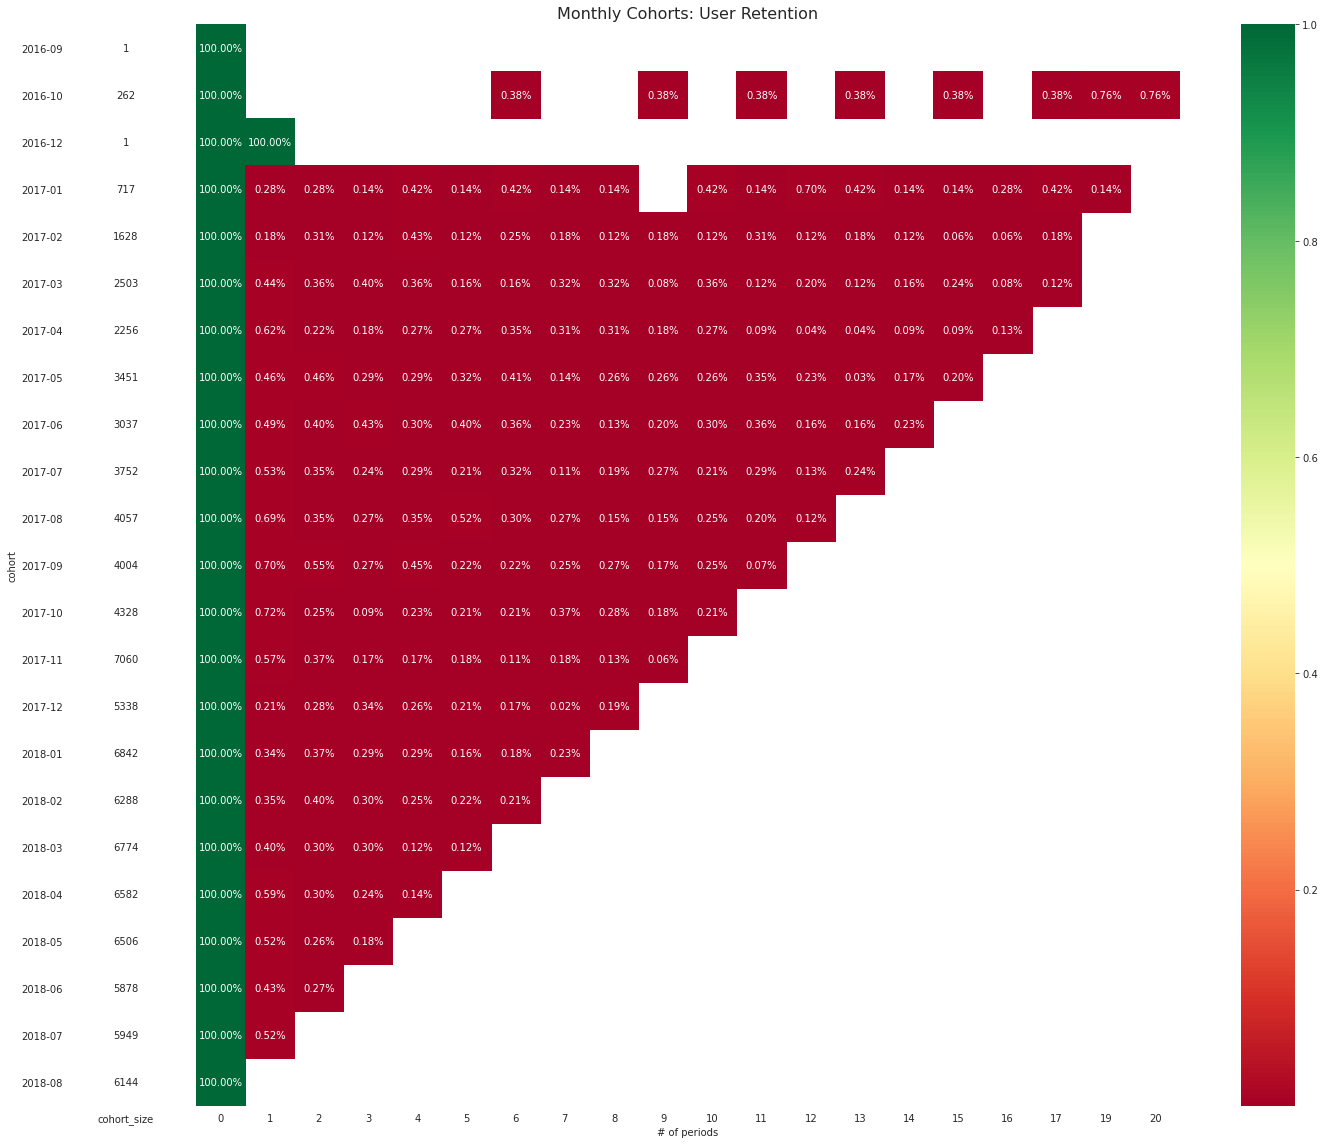

In [122]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 16), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
# Изображение матрицы

Как мы видим, retention очень низкий для всего перирода. Всегда меньше 1%. 

## 6.Построение RFM-сегментации пользователей и описание сегментов

In [58]:
# Для начала надо создать таблицу, в которой будет отражен id пользователя, дата совершения покупки (рассматриваем именно покупки, за дату рассматриваем транзакцию) и сумма покупки

In [123]:
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [124]:
# Сначала обратимся к items_df, чтобы определить сумму каждого заказа
order_price_df = items_df.groupby('order_id', as_index=False) \
    .agg({'price': 'sum'})
order_price_df.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [125]:
# Теперь получившуюся таблицу можно объединять с уже готовой объединенной таблицей с пользователями и покупками(customers_buyings_df) и оставить нужные нам колонки
for_rfm_df = customers_buyings_df.merge(order_price_df,on='order_id')[['customer_unique_id', 'order_purchase_timestamp', 'price']]
for_rfm_df.head()

,customer_unique_id,order_purchase_timestamp,price
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,139.94
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,149.94
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,230.00


In [126]:
# Для проведения RFM-анализа будем использовать данные за последний год. Сегодняшним чисом будем считать дату последней покупки, так как данные заканчиваются в 2018 году 

In [127]:
for_rfm_df['today'] = for_rfm_df.order_purchase_timestamp.max()
for_rfm_df.head()
# Добавили колонку с "сегодняшним" днем

,customer_unique_id,order_purchase_timestamp,price,today
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,124.99,2018-08-29 15:00:37
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,289.00,2018-08-29 15:00:37
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,139.94,2018-08-29 15:00:37
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,149.94,2018-08-29 15:00:37
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,230.00,2018-08-29 15:00:37


In [128]:
for_rfm_df = for_rfm_df.query('(today - order_purchase_timestamp).dt.days <= 365')
for_rfm_df.head()
# Оставили в таблице только данные о покупках за послнедний год

,customer_unique_id,order_purchase_timestamp,price,today
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,289.00,2018-08-29 15:00:37
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,139.94,2018-08-29 15:00:37
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,149.94,2018-08-29 15:00:37
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,230.00,2018-08-29 15:00:37
5,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,259.90,2018-08-29 15:00:37


In [129]:
# Создаем датафрейм, в котором указана дата последней покупки, количество покупок и потраченные деньги.
rfm_data = for_rfm_df.groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp':'max','price':['count', 'sum']}) \
    .reset_index() \
    .rename(columns={'max': 'last_buying', 'count':'num_buyings', 'sum':'spent_money'})
rfm_data.head()

customer_unique_id order_purchase_timestamp       price  \
                                                 last_buying num_buyings   
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27           1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27           1   
2  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41           1   
3  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42           1   
4  0004bd2a26a76fe21f786e4fbd80607f      2018-04-05 19:33:16           1   

               
  spent_money  
0      129.90  
1       18.90  
2       25.99  
3      180.00  
4      154.00

In [130]:
rfm_data.columns = ['customer_unique_id']+['last_buying']+['num_buyings']+['spent_money']
rfm_data.head()
# Убираем мультииндексы

,customer_unique_id,last_buying,num_buyings,spent_money
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1,154.00


In [67]:
# Теперь создадим колонку для метрики recency - времени между совершением последней покупки и текущей датой.

In [131]:
rfm_data['since_last_buying'] = (for_rfm_df['today'].max()-rfm_data['last_buying']).dt.days
rfm_data.head()
# Создали колонку с количеством дней с даты последней покупки пользователя

,customer_unique_id,last_buying,num_buyings,spent_money,since_last_buying
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,114
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,320
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,287
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1,154.00,145


In [132]:
# Теперь надо продумать метрики. 
# Для этого посмотрим на статистику получившихся показателей

In [133]:
# Проверяем на наличие пропущенных значений
rfm_data.isna().sum()

customer_unique_id    0
last_buying           0
num_buyings           0
spent_money           0
since_last_buying     0
dtype: int64

In [134]:
# Recency - как давно была совершена последняя покупка. Посмотрим на описание значений
rfm_data['since_last_buying'].describe()

count    72767.000000
mean       172.958072
std        100.339620
min          0.000000
25%         88.000000
50%        172.000000
75%        260.000000
max        365.000000
Name: since_last_buying, dtype: float64

In [135]:
# Есть возможность разделить на 4 равные группы по квантилям.
# Лучше всего для наших данных использовать именно квантили, так как у нас нет дополнительной информации о товарах, мы не можем оценить, как часто наши товары вообще могут продаваться (например, бытовую технику одни и те же пользователи покупают редко, а хозяйственные товары могут заказывать чаще).
# Из-за отсутствия информации о специфике наших товаров и аудитории, лучше использовать квантили - делить пользователей ра равные части. 

In [136]:
# Cоответственно, получим следующие оценки: от 260 дней - 1, от 172 до 260 - 2, от 88 до 172 - 3, до 88 - 4. Чем больше значение R, тем позже совершена последняя покупка, тем лучше.
# Добавим к данным колонку, отражающую recency.
rfm_data['R'] = pd.qcut(rfm_data['since_last_buying'], q=4, labels=[4, 3, 2, 1])
rfm_data.head()

,customer_unique_id,last_buying,num_buyings,spent_money,since_last_buying,R
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,111,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,114,3
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,320,1
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,287,1
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1,154.00,145,3


In [137]:
# Frequency - как часто совершались покупки. Мы будем использовать общее количество покупок, а не, например, среднее количество покупок в месяц или неделю.
# Это объясняется тем, что подавляющее большинство пользователей сделали только 1 покупку, либо просто совершали покупки очень редко.
# Нет смысла выбирать более маленький период для определения частоты.
rfm_data['num_buyings'].describe()
# Мы видим, что и среднее, и все квартили = 1.

count    72767.000000
mean         1.027403
std          0.186809
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: num_buyings, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


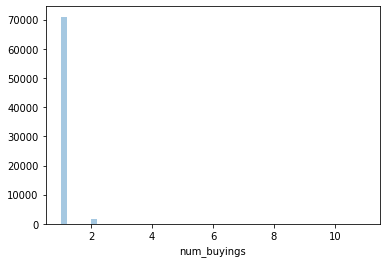

In [138]:
sns.distplot(rfm_data['num_buyings'], kde=False)
# Посмотрим на распределение кол-ва покупок на графике

In [139]:
# Смотрим, сколько пользователей сколько покупок совершили.
rfm_data['num_buyings'].value_counts()

1     70951
2      1693
3        95
4        17
5         6
7         3
11        1
9         1
Name: num_buyings, dtype: int64

In [140]:
# Пользоваться квартилями мы не можем, на равные части разбить точно не удастся. 
rfm_data['F'] = pd.cut(rfm_data['num_buyings'], bins=[0, 1, 2, 3, 15], labels=[1, 2, 3, 4])
#1 покупка - 1, 2 покупки - 2, 3 покупки - 3, от 4-х покупок - 4

In [141]:
rfm_data.F.value_counts()
# Получилось такое распределение количества элементов для каждого значения метрики

1    70951
2     1693
3       95
4       28
Name: F, dtype: int64

In [142]:
# Monetary - сколько денег было потрачено
# Здесь также будем смотреть на общее количество потраченных денег каждым пользователем (в связи с распределением количества покупок, большинство пользователей тратили эти суммы единовременно. Делить их, например, на количество месяцев или недель бессмысленно)
rfm_data['spent_money'].describe()

count    72767.000000
mean       141.348322
std        212.421513
min          0.850000
25%         47.900000
50%         89.800000
75%        152.375000
max      13440.000000
Name: spent_money, dtype: float64

In [143]:
# Разобъем по квантилям, как и recency и воспользуемся функцией pd.qcut
# до 47.9 - 1, от 47.9 до 89.8 - 2, от 89.8 до 152.375 - 3, от 152.375 - 4
rfm_data['M'] = pd.qcut(rfm_data['spent_money'], q=4, labels=[1, 2, 3, 4])

In [144]:
# Добавим столбец с названием rfm-сегмента для каждого полкупателя
rfm_data['rfm'] = rfm_data.R.astype(str)+rfm_data.F.astype(str)+rfm_data.M.astype(str)
rfm_data.head()

,customer_unique_id,last_buying,num_buyings,spent_money,since_last_buying,R,F,M,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,111,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,114,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,320,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,287,1,1,4,114
4,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1,154.00,145,3,1,4,314


In [145]:
# Теперь создадим итоговую таблицу с покупателями, их RFM-сегментами и описанием сегментов
rfm = rfm_data[['customer_unique_id','rfm', 'R', 'F', 'M']]
rfm.head()

,customer_unique_id,rfm,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,313,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,311,3,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,111,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,114,1,1,4
4,0004bd2a26a76fe21f786e4fbd80607f,314,3,1,4


In [146]:
# Пропишем функцию, которая будет давать описание для каждого rfm-сегмента
def description(x):
    if x[0] == '1':
        r = 'r > 260; '
    elif x[0] == '2':
        r = '172 > r ≤ 260; '
    elif x[0] == '3':
        r = '88 > r ≤ 172; '
    else:
        r = 'r ≤ 88; '
    if x[1] == '1':
        f = 'f = 1; '
    elif x[1] == '2':
        f = 'f = 2; '
    elif x[1] == '3':
        f = 'f = 3; '
    else:
        f = 'f ≥ 4 '
    if x[2] == '1':
        m = 'm ≤ 47.9'
    elif x[2] == '2':
        m = '47.9 < m ≤ 89.8'
    elif x[2] == '3':
        m = '89.8 < m ≤ 152.375'
    else:
        m = 'm > 152.375'
    return r+f+m
    

In [147]:
rfm['segment_description'] = rfm['rfm'].apply(description)
rfm.head()
# Итоговая таблица содержит информацию о каждом покупателе: егшо показатели, к какому сегменту он относится и в какие границы метрик он входит

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_unique_id,rfm,R,F,M,segment_description
0,0000366f3b9a7992bf8c76cfdf3221e2,313,3,1,3,88 > r ≤ 172; f = 1; 89.8 < m ≤ 152.375
1,0000b849f77a49e4a4ce2b2a4ca5be3f,311,3,1,1,88 > r ≤ 172; f = 1; m ≤ 47.9
2,0000f6ccb0745a6a4b88665a16c9f078,111,1,1,1,r > 260; f = 1; m ≤ 47.9
3,0004aac84e0df4da2b147fca70cf8255,114,1,1,4,r > 260; f = 1; m > 152.375
4,0004bd2a26a76fe21f786e4fbd80607f,314,3,1,4,88 > r ≤ 172; f = 1; m > 152.375


In [148]:
rfm_info = rfm.groupby('rfm', as_index=False) \
    .agg({'R':'max', 'F':'max', 'M':'max', 'segment_description': 'max', 'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id': 'num_customers'}) \
    .sort_values('rfm')
rfm_info
# В этой таблице отражена информация для каждого сегмента: количество относящихся к нему покупателей и границы сегмента

,rfm,R,F,M,segment_description,num_customers
0,111,1,1,1,r > 260; f = 1; m ≤ 47.9,4374
1,112,1,1,2,r > 260; f = 1; 47.9 < m ≤ 89.8,4691
2,113,1,1,3,r > 260; f = 1; 89.8 < m ≤ 152.375,4314
3,114,1,1,4,r > 260; f = 1; m > 152.375,4443
4,121,1,2,1,r > 260; f = 2; m ≤ 47.9,8
5,122,1,2,2,r > 260; f = 2; 47.9 < m ≤ 89.8,56
6,123,1,2,3,r > 260; f = 2; 89.8 < m ≤ 152.375,95
7,124,1,2,4,r > 260; f = 2; m > 152.375,184
8,133,1,3,3,r > 260; f = 3; 89.8 < m ≤ 152.375,1
9,134,1,3,4,r > 260; f = 3; m > 152.375,7


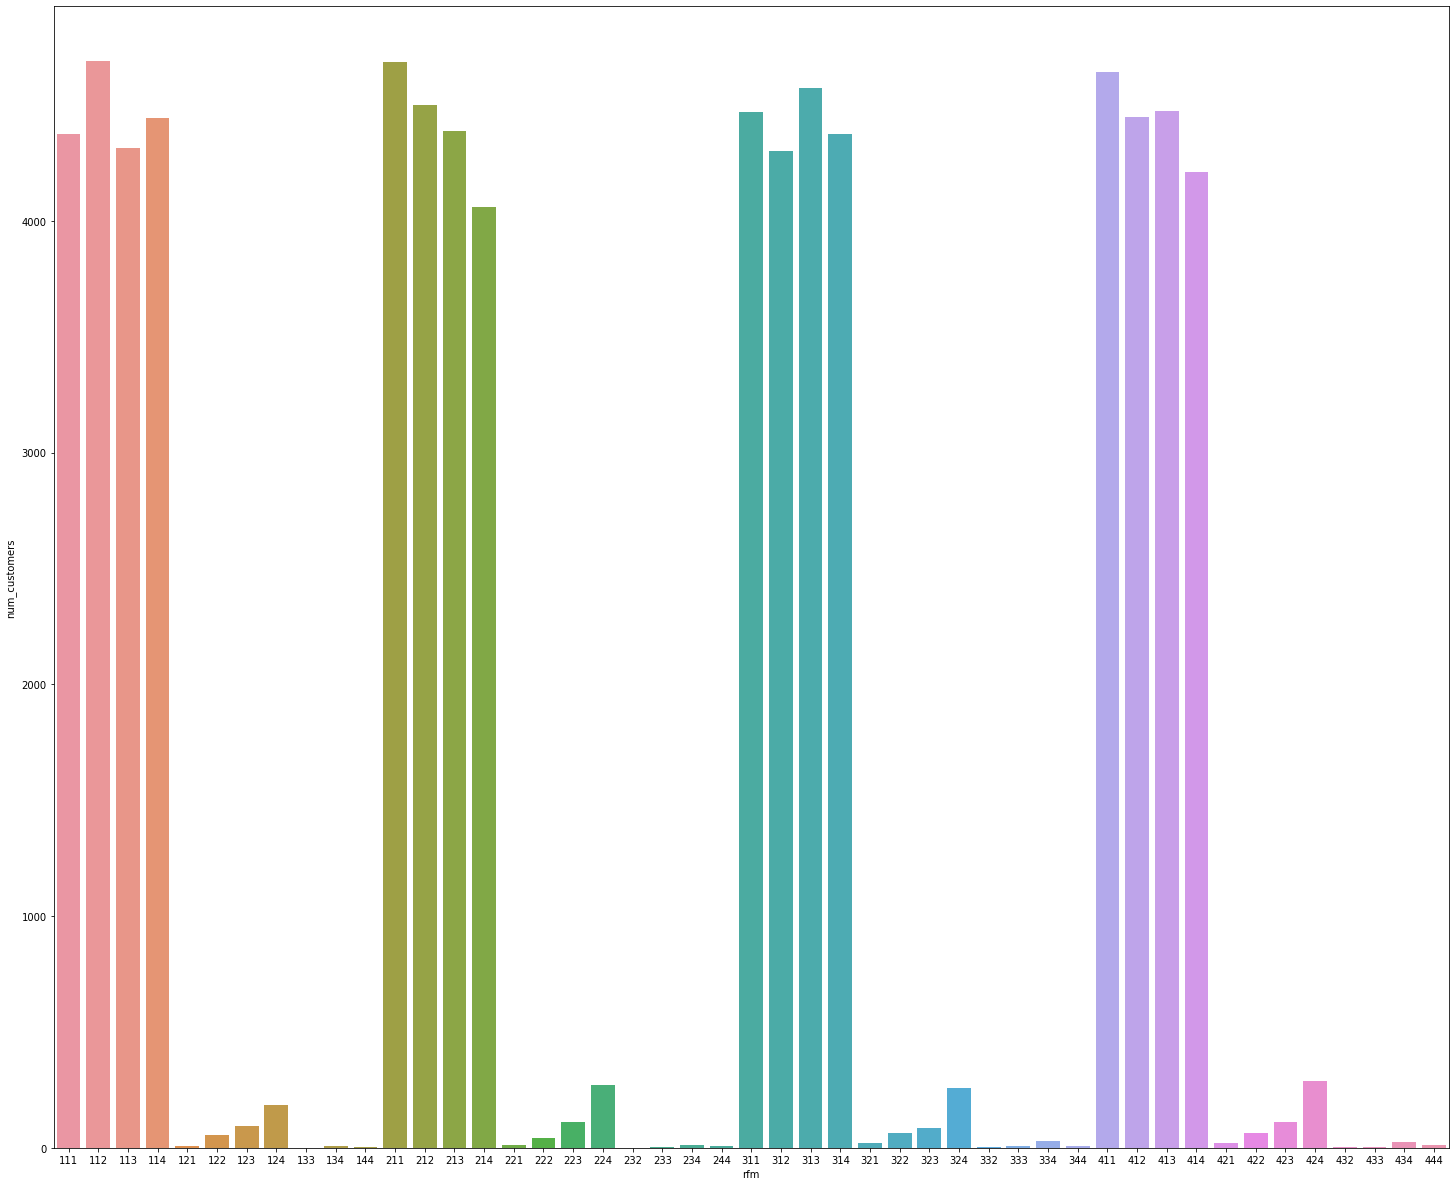

In [86]:
plt.figure(figsize=(25, 21))
sns.barplot(data=rfm_info, x='rfm', y='num_customers')
# График, отражающий количество покупателей в каждом сегменте. Наиболее маленькие сегменты - с высокими и средними (больше 1) показателем frequency (что объясняется маленьким количеством покупок у большинства пользователей).

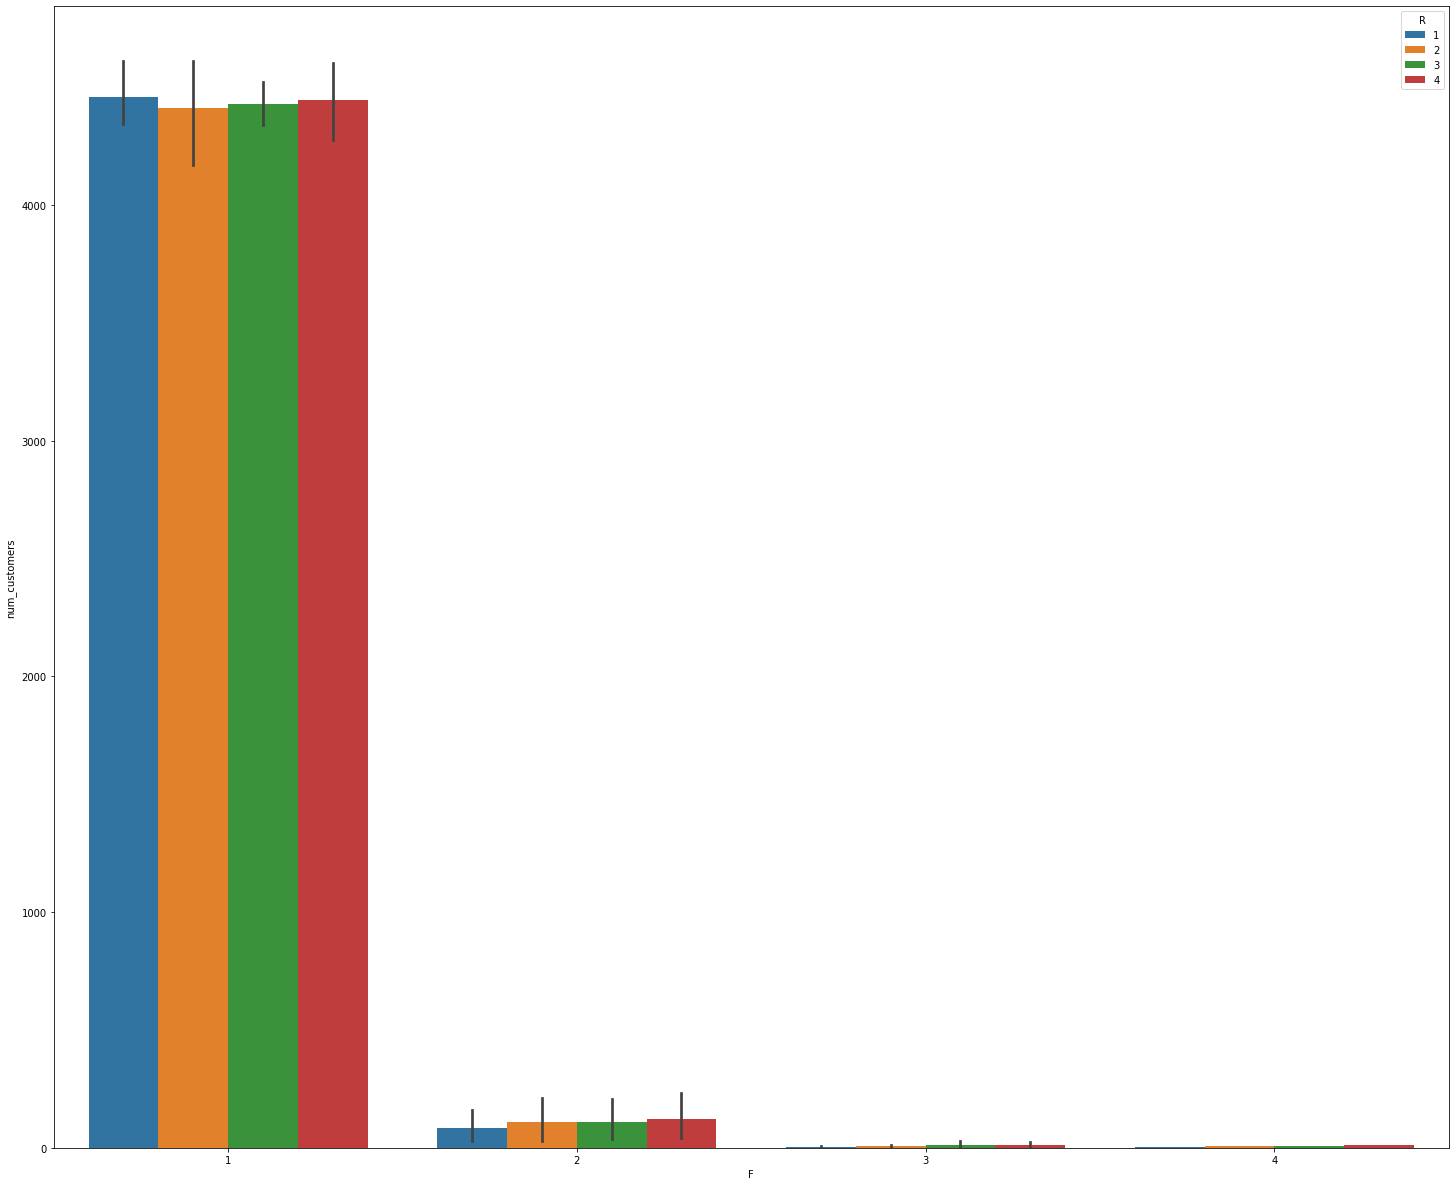

In [149]:
plt.figure(figsize=(25, 21))
sns.barplot(data=rfm_info, x='F', y='num_customers', hue='R')
# График, отражающий количество покупателей с разными значениями frequency взависимости от их значения recency

Обращая внимание на специфику данных, можно отметить, что покупатели редко совершают больше одной покупки. Если перед нами стоит цель увеличить удержание клиентов, то стоит обратиться к сегментам с высоким recency (3-4). Возможно, получится убедить покупателей, совершивших покупку недавно, сделать это снова. Особенное внимание можно уделить пользователям с относительно высокими показателями frequency (от 3х покупок), они могут быть более предрасположены совершать новые покупки. Покупатели с низким recency (1-2) и frequency от 3х покупок могут быть возвращены. Низкие показатели и frequency, и recency говорят о том, что принадлежащие к этим сегментам покупатели скорее всего потеряны.
Надеяться только лишь на тех, кто совершил относительно большое количество покупок, не стоит - их слишком мало. Лучше всего ориентироваться на всех, кто совершил последнюю покупку недавно. При этом стратегию удержания пользователей в любом случае необходимо пересмотреть.